In [1]:
import jax 
import jax.numpy as jnp

# check if gpu can be used
def jax_has_gpu():
    try:
        _ = jax.device_put(jax.numpy.ones(1), device=jax.devices('gpu')[0])
        return True
    except:
        return False

jax_has_gpu()



False

In [2]:
!wget https://files.rcsb.org/download/1UAO.pdb -q -O chignolin_ensemble.pdb

In [3]:
import mdtraj

traj = mdtraj.load('chignolin_ensemble.pdb')
top = traj.topology
traj

/Users/ziyuanzhao/miniforge3/envs/jax/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


<mdtraj.Trajectory with 18 frames, 138 atoms, 10 residues, without unitcells at 0x16117fd60>

In [4]:
top

<mdtraj.Topology with 1 chains, 10 residues, 138 atoms, 141 bonds at 0x1610bbc40>

In [5]:
import networkx as nx
from consts import basis_Zs

# this is a demo for residue gas representation in Minhuan's code
def top_to_comp_DAG(top: mdtraj.Topology, mask=None):
    G = nx.DiGraph()
    
    # first find root nodes, which are N, CA, C atoms
    backbone_atom_names = ['CA', 'C', 'N']
    backbone_atom_ids = top.select(' '.join(["name " + atom_name for atom_name in backbone_atom_names]))
    G.add_nodes_from([(i, {'ic': i not in backbone_atom_ids}) for i in range(top.n_atoms)])
    
    # implement atom mask later
    # implement multi-chain processing later
    for i, res in enumerate(top.residues):
        atom_name_to_id = {a.name: a.index for a in res.atoms}
        
        for entry in basis_Zs[res.name]:  # template entry:
            cur_id = atom_name_to_id[entry[0]]
            G.add_edges_from([(atom_name_to_id[refatom], cur_id, {'id': 2-j}) for j, refatom in enumerate(entry[1:])]) # j = 0,1,2
        
        # implement any fix later
        if i == 0: # c-terminal
            G.add_edges_from([(atom_name_to_id['N'], atom_name_to_id['H2'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['H2'], {'id': 1}),
                              (atom_name_to_id['C'], atom_name_to_id['H2'], {'id': 0})])
            G.add_edges_from([(atom_name_to_id['N'], atom_name_to_id['H3'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['H3'], {'id': 1}),
                              (atom_name_to_id['C'], atom_name_to_id['H3'], {'id': 0})])
        elif i == top.n_residues-1: # n-term
            G.add_edges_from([(atom_name_to_id['C'], atom_name_to_id['OXT'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['OXT'], {'id': 1}),
                              (atom_name_to_id['N'], atom_name_to_id['OXT'], {'id': 0})])
            
    return G

In [6]:
def top_to_comp_DAG_sequential(top: mdtraj.Topology) -> nx.DiGraph:
    G = nx.DiGraph()
    # first find root nodes, which are N, CA, C atoms
    backbone_atom_names = ['CA', 'C', 'N']
    backbone_atom_ids = top.select(' '.join(["name " + atom_name for atom_name in backbone_atom_names]))
    backbone_atom_ids.sort()
        
    # we only use cartesian coordinate on the first three backbone atoms
    G.add_nodes_from([(i, {'ic': i not in backbone_atom_ids[:3]}) for i in range(top.n_atoms)])
    
    # add backbone computing dependencies
    for i in range(3, len(backbone_atom_ids)):
         G.add_edges_from([(backbone_atom_ids[i-3], backbone_atom_ids[i], {'id': 0}),
                            (backbone_atom_ids[i-2], backbone_atom_ids[i], {'id': 1}),
                            (backbone_atom_ids[i-1], backbone_atom_ids[i], {'id': 2})])
    
    for i, res in enumerate(top.residues):
        atom_name_to_id = {a.name: a.index for a in res.atoms}
        
        for entry in basis_Zs[res.name]:  # template entry:
            cur_id = atom_name_to_id[entry[0]]
            G.add_edges_from([(atom_name_to_id[refatom], cur_id, {'id': 2-j}) for j, refatom in enumerate(entry[1:])]) # j = 0,1,2
        
        # implement any fix later
        if i == 0: # c-terminal
            G.add_edges_from([(atom_name_to_id['N'], atom_name_to_id['H2'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['H2'], {'id': 1}),
                              (atom_name_to_id['C'], atom_name_to_id['H2'], {'id': 0})])
            G.add_edges_from([(atom_name_to_id['N'], atom_name_to_id['H3'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['H3'], {'id': 1}),
                              (atom_name_to_id['C'], atom_name_to_id['H3'], {'id': 0})])
        elif i == top.n_residues-1: # n-term
            G.add_edges_from([(atom_name_to_id['C'], atom_name_to_id['OXT'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['OXT'], {'id': 1}),
                              (atom_name_to_id['N'], atom_name_to_id['OXT'], {'id': 0})])
        
    
    return G

In [7]:
G_residue_gas = top_to_comp_DAG(top)
G_sequential = top_to_comp_DAG_sequential(top)

import matplotlib.pyplot as plt

def visualize_DAG(G: nx.DiGraph, top: mdtraj.Topology):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    pos = nx.multipartite_layout(G, subset_key="layer")
    
    # jitter position of nodes to avoid overlapping edges
#     for k in pos.keys():
#         pos[k][1] += np.random.random(1) * 0.02
    
    fig, ax = plt.subplots(figsize=(10,10))
    atom_names = [a.name for a in top.atoms]
    nx.draw_networkx(G, pos, node_size=200, 
                     node_color=["#ffffa1" if name in ['C', 'CA', 'N'] else "#90e0ef" for name in atom_names],
                     with_labels=False)
    nx.draw_networkx_labels(G, pos, font_color='k', font_size=5, 
                            labels=dict([(i, str(n).replace('-', '\n')) for i, n in enumerate(top.atoms)]))
    

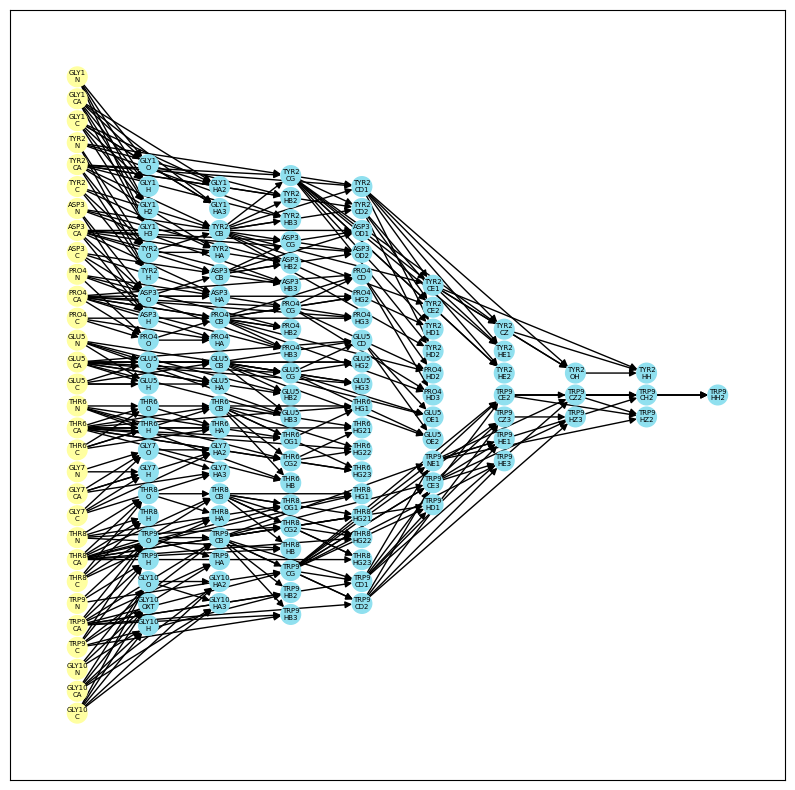

In [8]:
visualize_DAG(G_residue_gas, top)

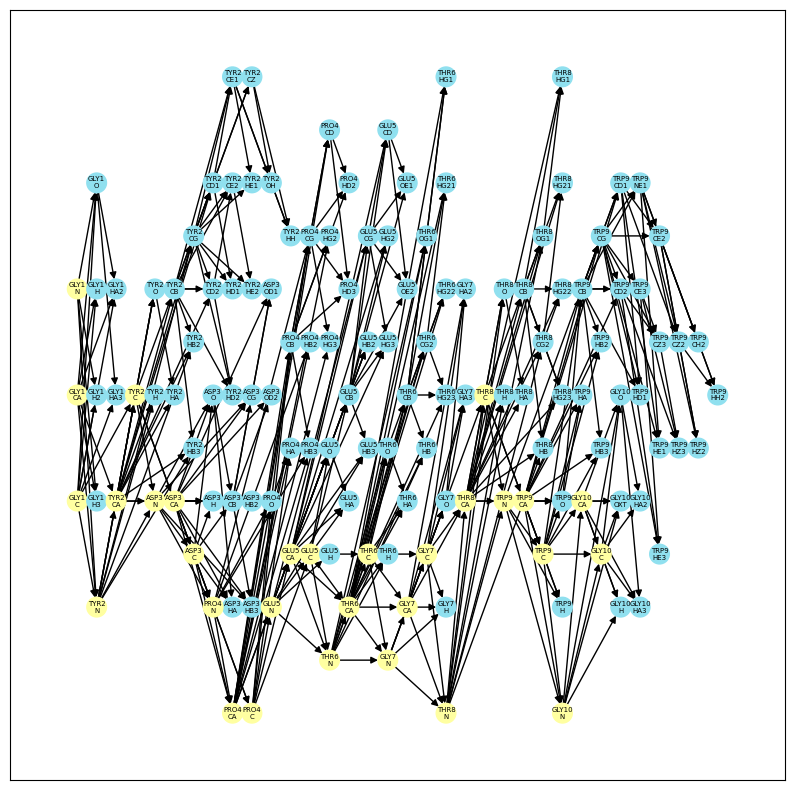

In [9]:
visualize_DAG(G_sequential, top)

In [10]:
import jax
import jax.numpy as jnp
from abc import ABC, abstractmethod
from typing import List
from jax.tree_util import tree_flatten, tree_unflatten

# we will abuse terminology and take frame and coordinate system to be roughly synonymous

class CoordinateSystem(ABC):
    @abstractmethod
    def to_local(self, coords):
        pass

    @abstractmethod
    def to_global(self, coords):
        pass

class AffineFrame(CoordinateSystem):
    def __init__(self, R, t, Ri=None):
        self.R = R # 3*3 
        self.Ri = jnp.linalg.inv(R) if Ri is None else Ri
        self.t = t # 3*1

    def to_local(self, coords):
        return jnp.einsum('...ik,...k->...i',
                          self.Ri, coords - self.t)

    def to_global(self, coords):
        """
        coords: n_batch * n_points * 3 
        """
        return self.t + jnp.einsum('...ik,...k->...i',
                                   self.R, coords)
    
    def _tree_flatten(self):
        children = (self.R, self.Ri, self.t)  # arrays / dynamic values
        aux_data = None
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        R, Ri, t = children
        return cls(R=R, Ri=Ri, t=t)
    
from jax import tree_util
tree_util.register_pytree_node(AffineFrame,
                               AffineFrame._tree_flatten,
                               AffineFrame._tree_unflatten)
# class CartesianFrame(AffineFrame):
  
class SphericalFrame(CoordinateSystem):
    def __init__(self, permutation=[0,1,2]):
        self.permutation = permutation
        self.inverse = tuple(permutation.index(i) for i in range(len(permutation)))
        
    
    def to_local(self, coords):
        x, y, z = coords[..., 0:1], coords[..., 1:2], coords[..., 2:3]
        r = jnp.sqrt(x*x+y*y+z*z)
        theta = jnp.arctan2(y, x)
        phi = jnp.arccos(z/r)
        out = [r, theta, phi]
        return jnp.concatenate([out[i] for i in self.permutation], axis=-1)
    
    def to_global(self, coords):
        in_ = (coords[..., 0:1], coords[..., 1:2], coords[..., 2:3])
        r, theta, phi = (in_[i] for i in self.inverse)
        x = r * jnp.cos(theta) * jnp.sin(phi)
        y = r * jnp.sin(theta) * jnp.sin(phi)
        z = r * jnp.cos(phi)
        return jnp.concatenate([x, y, z], axis=-1)

    def _tree_flatten(self):
        children = self.permutation
        aux_data = None
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        permutation = children
        return cls(permutation)

tree_util.register_pytree_node(SphericalFrame,
                               # lambda x: ((), x._tree_flatten()),
                               SphericalFrame._tree_flatten,
                               SphericalFrame._tree_unflatten)
def check_same_type(lst):
    if not lst:
        return True  # empty list is considered as having the same type
    first_type = type(lst[0])
    return all(type(item) == first_type for item in lst[1:])

# from jax.lib import pytree
def concatenate_trees(trees, axis=0):
    """
    Takes a list of trees and concatenates every corresponding leaf (assuming is array)
    Shallow concatenation, not recursive
    """
    leaves_list = []
    treedef_list = []
    for tree in trees:
        leaves, treedef = tree_flatten(tree)
        leaves_list.append(leaves)
        treedef_list.append(treedef)

    grouped_leaves = zip(*leaves_list)
    result_leaves = [jnp.concatenate(l, axis=axis) for l in grouped_leaves]
    return treedef_list[0].unflatten(result_leaves)

def concatenate_frames(frames: List[CoordinateSystem]) -> CoordinateSystem:
    # assert check_same_type(frames)
    return concatenate_trees(frames, axis=1)

def sort_frame(frame: CoordinateSystem, perm) -> CoordinateSystem:
    leaves, treedef = tree_flatten(frame)
    leaves_sorted = []
    for leave in leaves:
        leaves_sorted.append(leave[:, perm, ...])
    return treedef.unflatten(leaves_sorted)

In [11]:
from typing import Callable
from functools import partial
import numpy as np

def DAG_to_Z_indices(DAG: nx.DiGraph, n_atoms: int):
    """
    returns Z_indices: n_atoms * 4 array of masked Z index (zero for Cartesian repr-ed atom rows)
    """
    Z_indices = np.zeros((n_atoms, 4), dtype=np.int32)
    for (ref_atom_id, cur_atom_id, d) in DAG.edges(data=True):
        Z_indices[cur_atom_id, 1+d['id']] = ref_atom_id
        Z_indices[cur_atom_id, 0] = cur_atom_id
    return Z_indices

def DAG_to_Z_index_groups(DAG: nx.DiGraph):
    groups = []
    for layer, nodes in enumerate(nx.topological_generations(DAG)):
        n_atoms = len(nodes)
        Z_indices = np.zeros((n_atoms, 4), dtype=np.int32)
        for row_id, cur_atom_id in enumerate(nodes):
            if DAG.nodes[cur_atom_id]['layer'] == 0:
                Z_indices[row_id, 0] = cur_atom_id
                Z_indices[row_id, 1:] = -1
            else:
                for (ref_atom_id, _, d) in DAG.in_edges(cur_atom_id, data=True):
                    Z_indices[row_id, 1+d['id']] = ref_atom_id
                    Z_indices[row_id, 0] = cur_atom_id
        groups.append(Z_indices)
    return groups

@jax.jit
def build_frame(x1, x2, x3) -> CoordinateSystem:
    """
    x1, x2, x3 are the three atoms before x4, whose coordinate we want to express 
    in the local frame computed from x1, x2, x3. This algorithm is based on NeRF.
    
    x1: n_atoms * 3 array
    """
    bc = x3 - x2
    bc = bc / jnp.linalg.norm(bc, axis=-1, keepdims=True) # normalize
    
    n = jnp.cross(bc, x1-x2, axisa=-1, axisb=-1)
    n = n / jnp.linalg.norm(n, axis=-1, keepdims=True)
    
    nxbc = jnp.cross(n, bc, axisa=-1, axisb=-1)
    
    coordaxes = jnp.concatenate([nxbc[..., None], n[..., None], -bc[..., None]], axis=-1)
        
    return AffineFrame(R=coordaxes, t=x3[..., :])

    
ref_spherical_frame = SphericalFrame(permutation=(0,2,1))


class ICTransformation():
    
    def __init__(self, top: mdtraj.Topology, DAG: nx.DiGraph=None, 
                 conversion_scheme: Callable[mdtraj.Topology, nx.DiGraph]=None,
                 build_frame: Callable[[jnp.array, jnp.array, jnp.array], CoordinateSystem]=None):
        self.topology = top
        self.n_atoms = top.n_atoms
        self.DAG = DAG if DAG is not None else conversion_scheme(self.topology)
        self.Z_index_groups = DAG_to_Z_index_groups(self.DAG)
        self.flat_Z_indices = jnp.concatenate([Z_indices[..., 0] for Z_indices in self.Z_index_groups])
        self.ic_indices = jnp.array([i for i,n in self.DAG.nodes(data=True) if n['ic']==True], dtype=np.int32)
        self.n_groups = len(self.Z_index_groups)
        self.Z_index_group_sizes = [len(group) for group in self.Z_index_groups]
        self.build_frame = build_frame
    
    def get_frame_and_xyz_local(self, xyz):
        frame_lst = []
        xyz_transformed_lst = []

        for layer in range(self.n_groups):
            Z_indices = self.Z_index_groups[layer]
            positions = xyz[..., Z_indices[:, 0], :]
            if layer == 0:
                R0 = jnp.tile(jnp.eye(3)[None, None,...], (positions.shape[0], positions.shape[1], 1, 1))
                # assumes first layer start from the default global frame (Cartesian)
                frame = AffineFrame(R=R0, Ri=R0,
                                    t=jnp.zeros((positions.shape[0], positions.shape[1], 3)))
                xyz_transformed = positions
            else:
                frame = self.build_frame(xyz[..., Z_indices[:, 1], :], 
                                         xyz[..., Z_indices[:, 2], :], 
                                         xyz[..., Z_indices[:, 3], :]) # ref positions
            xyz_transformed = frame.to_local(positions)
            frame_lst.append(frame)
            xyz_transformed_lst.append(xyz_transformed)

        # stitch results from each layer into output
        frames = concatenate_frames(frame_lst)
        xyz_transformed = jnp.concatenate(xyz_transformed_lst, axis=1)

        perm = jnp.argsort(self.flat_Z_indices)
        frames = sort_frame(frames, perm)
        xyz_transformed = xyz_transformed[..., perm, :]
        return frames, xyz_transformed
        
    def get_frame_and_xyz_global(self, xyz):
        frame_lst = []

        for layer in range(self.n_groups):
            Z_indices = self.Z_index_groups[layer]
            positions = xyz[..., Z_indices[:, 0], :]
            if layer == 0:
                R0 = jnp.tile(jnp.eye(3)[None, None,...], (positions.shape[0], positions.shape[1], 1, 1))
                # assumes first layer start from the default global frame (Cartesian)
                frame = AffineFrame(R=R0, Ri=R0,
                                    t=jnp.zeros((positions.shape[0], positions.shape[1], 3)))
                xyz_transformed = positions
            else:
                frame = self.build_frame(xyz[..., Z_indices[:, 1], :], 
                                         xyz[..., Z_indices[:, 2], :], 
                                         xyz[..., Z_indices[:, 3], :]) # ref positions
                xyz_transformed = frame.to_global(positions)
            frame_lst.append(frame)
            xyz = xyz.at[..., Z_indices[:, 0], :].set(xyz_transformed)

        # stitch results from each layer into output
        frames = concatenate_frames(frame_lst)
        perm = jnp.argsort(self.flat_Z_indices)
        frames = sort_frame(frames, perm)
        return frames, xyz
    
    def xyz2ic(self, xyz: jnp.array, vec_angles=False):
        """
        xyz : n_batch * n_atoms * 3 array of Cartesian coordinates
        """
        
        frames, xyz_local = self.get_frame_and_xyz_local(xyz)
        
        # convert some to IC coordinates
        ic = xyz_local.at[..., self.ic_indices, :].set(\
            ref_spherical_frame.to_local(xyz_local[..., self.ic_indices, :])
        )
                
        if vec_angles:
            pass
        
        return frames, ic
            
    # need to deal with pure IC repr later
    def ic2xyz(self, ic):
        """
        ic: n_batch * n_atoms * 3 array of mixed coordinates 
        (Cartesian coordinates are used to initialize computation)
        """
        xyz_local = ic.at[..., self.ic_indices, :].set(\
            ref_spherical_frame.to_global(ic[..., self.ic_indices, :])
        )
        
        frames, xyz = self.get_frame_and_xyz_global(xyz_local)
        return frames, xyz

In [12]:
ict = ICTransformation(top=top, DAG=G_residue_gas, build_frame=build_frame)

In [13]:
# This is a mapping that can be compared to Minhuan's implementation
# for this structure, atomid 25 and 18 are swapped up, not sure why yet.

ict.flat_Z_indices

DeviceArray([  0,   1,   2,   9,  10,  11,  30,  31,  32,  42,  43,  44,
              56,  57,  58,  71,  72,  73,  85,  86,  87,  92,  93,  94,
             106, 107, 108, 130, 131, 132,   4,   3,   5,   6,  21,  12,
              38,  33,  45,  65,  59,  78,  74,  89,  88,  99,  95, 120,
             109, 135, 133, 134,   7,   8,  22,  13,  39,  34,  49,  46,
              66,  60,  79,  75,  90,  91, 100,  96, 121, 110, 136, 137,
              14,  23,  24,  35,  40,  41,  47,  50,  51,  61,  67,  68,
              76,  77,  80,  97,  98, 101, 122, 123, 111,  15,  16,  36,
              37,  48,  52,  53,  62,  69,  70,  81,  82,  83,  84, 102,
             103, 104, 105, 112, 113,  17,  25,  18,  26,  54,  55,  63,
              64, 124, 114, 116,  19,  27,  28, 125, 115, 126, 118,  20,
             117, 128,  29, 127, 119, 129], dtype=int32)

In [14]:
xyz_0 = jnp.tile(jnp.array(traj.xyz), (1, 1, 1))
print(xyz_0.shape)
frames, ic = ict.xyz2ic(xyz_0)
frames, xyz = ict.ic2xyz(ic)

(18, 138, 3)


In [15]:
# check RMSD, thanks for Minhuan's suggestion
jnp.mean(jnp.sqrt(jnp.sum((xyz-xyz_0)**2, axis=-1)))

DeviceArray(2.6524589e-08, dtype=float32)

In [16]:
import numpy as np

np.save('chignolin_ic.npy', np.array(ic[:,ict.flat_Z_indices,:]))

In [ ]:
# let's try Minhuan's implementation in pytorch from https://github.com/minhuanli/deeprefine

import deeprefine
import torch
converter = deeprefine.ICConverter(top, vec_angles=False)
xyz_0_torch = torch.Tensor(traj.xyz.reshape(18, -1))
ic_torch = converter.xyz2ic(xyz0).reshape(18, -1, 3)

In [ ]:
jnp.isclose(ic[:,ict.flat_Z_indices,:][0], jnp.array(ic_torch[0]))

In [19]:
test_xyz2ic = lambda: ict.xyz2ic(xyz_0)
test_ic2xyz = lambda: ict.ic2xyz(ic)
_ =test_xyz2ic()
_ =test_ic2xyz()

In [ ]:
%%timeit
test_xyz2ic()

In [17]:
%%timeit
test_ic2xyz()

22.4 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
import cProfile
cProfile.run('test_xyz2ic()', 'xyz2ic_stats')

In [22]:
cProfile.run('test_ic2xyz()', 'ic2xyz_stats')

In [23]:
import pstats
from pstats import SortKey
p = pstats.Stats('ic2xyz_stats')
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(20)

Sat Apr 22 13:04:29 2023    ic2xyz_stats

         130653 function calls (130336 primitive calls) in 0.084 seconds

   Ordered by: cumulative time
   List reduced from 384 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.084    0.084 {built-in method builtins.exec}
        1    0.000    0.000    0.084    0.084 <string>:1(<module>)
        1    0.000    0.000    0.084    0.084 3224289598.py:2(<lambda>)
        1    0.000    0.000    0.084    0.084 1409614985.py:144(ic2xyz)
        1    0.001    0.001    0.063    0.063 1409614985.py:100(get_frame_and_xyz_global)
       45    0.000    0.000    0.052    0.001 lax_numpy.py:3770(_rewriting_take)
       56    0.002    0.000    0.049    0.001 lax_numpy.py:3924(_index_to_gather)
       45    0.000    0.000    0.047    0.001 lax_numpy.py:3822(_gather)
      324    0.000    0.000    0.033    0.000 core.py:326(bind)
      324    0.000    0.000    0.030    0.000 

In [24]:
p = pstats.Stats('xyz2ic_stats')
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(20)

Sat Apr 22 13:04:28 2023    xyz2ic_stats

         105856 function calls (105593 primitive calls) in 0.070 seconds

   Ordered by: cumulative time
   List reduced from 384 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.070    0.070 {built-in method builtins.exec}
        1    0.000    0.000    0.070    0.070 <string>:1(<module>)
        1    0.000    0.000    0.070    0.070 3224289598.py:1(<lambda>)
        1    0.000    0.000    0.070    0.070 1409614985.py:126(xyz2ic)
        1    0.001    0.001    0.067    0.067 1409614985.py:70(get_frame_and_xyz_local)
       46    0.000    0.000    0.057    0.001 lax_numpy.py:3770(_rewriting_take)
       46    0.000    0.000    0.051    0.001 lax_numpy.py:3822(_gather)
       47    0.001    0.000    0.039    0.001 lax_numpy.py:3924(_index_to_gather)
      280    0.000    0.000    0.031    0.000 core.py:326(bind)
      280    0.000    0.000    0.029    0.000 co